In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pykrx import stock

stock_num = '035420'
start_date = '2010-01-01'
end_date = '2025-03-17'

df_naver = yf.download(f"{stock_num}.KS", start=start_date, end=end_date)
df_naver.columns = df_naver.columns.droplevel(1)
df_naver.columns.name = None
df_naver.index.name = None
df_naver = df_naver.T

df_naver_stat = stock.get_market_fundamental(start_date, end_date, ticker=f"{stock_num}")


[*********************100%***********************]  1 of 1 completed


In [34]:
df_naver_stat

,BPS,PER,PBR,EPS,DIV,DPS
날짜,,,,,,
2010-01-04,25143,24.250,7.680,7959,0.000,0
2010-01-05,25143,24.250,7.680,7959,0.000,0
2010-01-06,25143,24.120,7.640,7959,0.000,0
2010-01-07,25143,24.190,7.660,7959,0.000,0
2010-01-08,25143,23.370,7.400,7959,0.000,0
...,...,...,...,...,...,...
2025-03-11,154077,31.900,1.380,6661,0.570,1205
2025-03-12,154077,32.130,1.390,6661,0.560,1205
2025-03-13,154077,32.430,1.400,6661,0.560,1205


In [35]:
PER = df_naver_stat['PER']
PBR = df_naver_stat['PBR']
EPS = df_naver_stat['EPS']

price_dates = pd.to_datetime(df_naver.columns)
fund_dates  = pd.to_datetime(PER.index)
common_dates = price_dates.intersection(fund_dates).sort_values()

In [36]:
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

# start date = 2002_01 // end date = 2025_04
df_GDP = pd.read_csv('data/GDP_0201to2504.csv', index_col=0)
df_GDP = df_GDP.iloc[:, 4:].reset_index(drop=True)
df_GDP.index = ['real_GDP'] # 실질 GDP

df_GDP.columns = pd.PeriodIndex(
    df_GDP.columns.str.replace('/', ''),  # '2002/Q2' → '2002Q2'
    freq='Q'
)

def add_new_row(df_stock, df_add):
    df_new = df_stock.copy()
    new_row = df_add.index[0]   # '실질_GDP'

    # df_stock.columns(원래 날짜 문자열)을 분기 PeriodIndex 로 변환
    periods = pd.to_datetime(df_new.columns).to_period('Q')
    values = df_add.loc[new_row].reindex(periods).values
    df_new.loc[new_row] = values

    return df_new


def add_metric_row(df_stock, series, row_name):
    """
    df_stock: 열이 날짜 문자열로 된 DataFrame
    series: 날짜 문자열 인덱스의 pandas Series (e.g. PER or PBR)
    row_name: 새로 추가할 행 이름 (e.g. 'PER', 'PBR')
    """
    df_new = df_stock.copy()
    
    # 1) df_stock.columns → PeriodIndex('D')
    periods = pd.to_datetime(df_new.columns).to_period('D')
    
    # 2) series.index → PeriodIndex('D')
    ser = series.copy()
    ser.index = pd.to_datetime(ser.index).to_period('D')
    
    # 3) reindex → values
    values = ser.reindex(periods).values
    
    # 4) 새 행 추가
    df_new.loc[row_name] = values
    return df_new

# 기존에 GDP 행을 추가한 df_naver_add에 PER, PBR도 같은 기준으로 추가
df_naver_add = add_new_row(df_naver, df_GDP)        # 실질_GDP
df_naver_add = add_metric_row(df_naver_add, PER, 'PER')
df_naver_add = add_metric_row(df_naver_add, PBR, 'PBR')
df_naver_add = add_metric_row(df_naver_add, EPS, 'EPS')
df_naver_add = df_naver_add.T
df_naver_add.index.name = 'date'
df_naver_add.index

df_naver_add[df_naver_add[['PER', 'PBR', 'EPS']].isnull().any(axis=1)]

,Close,High,Low,Open,Volume,real_GDP,PER,PBR,EPS
date,,,,,,,,,
2015-08-14,100963.039,100963.039,100963.039,100963.039,0.000,1.500,NaN,NaN,NaN


In [37]:
## (PER,PBR) 2015-08-14가 결측임
# PER
pre  = df_naver_add.loc['2015-08-13','PER']
nxt  = df_naver_add.loc['2015-08-17','PER']
df_naver_add.loc['2015-08-14','PER'] = (pre + nxt) / 2

# PBR
pre2 = df_naver_add.loc['2015-08-13','PBR']
nxt2 = df_naver_add.loc['2015-08-17','PBR']
df_naver_add.loc['2015-08-14','PBR'] = (pre2 + nxt2) / 2

# EPS
pre3 = df_naver_add.loc['2015-08-13','EPS']
nxt3 = df_naver_add.loc['2015-08-17','EPS']
df_naver_add.loc['2015-08-14','EPS'] = (pre3 + nxt3) / 2

In [ ]:
## 기술적 지표 ##
# 추가할 window sizes
window_sizes = [5, 10, 20, 30, 60]

# 기존 변수명 유지하며 추가 지표 계산
for window in window_sizes:
    df_naver_add[f'SMA_{window}'] = df_naver_add['Close'].rolling(window=window).mean()
    df_naver_add[f'EMA_{window}'] = df_naver_add['Close'].ewm(span=window, adjust=False).mean()
    
    delta = df_naver_add['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    df_naver_add[f'RSI_{window}'] = 100 - (100 / (1 + rs))

# 결측값 채운건데 start date 이전의 데이터를 기반으로 계산하는 방법도 있음   
df_naver_add.interpolate(method='bfill', inplace=True)

In [42]:
df_naver_add.to_csv("data/df_naver_add.csv")
print(df_naver_add.isnull().sum())

Close       0
High        0
Low         0
Open        0
Volume      0
real_GDP    0
PER         0
PBR         0
EPS         0
SMA_5       0
EMA_5       0
RSI_5       0
SMA_10      0
EMA_10      0
RSI_10      0
SMA_20      0
EMA_20      0
RSI_20      0
SMA_30      0
EMA_30      0
RSI_30      0
SMA_60      0
EMA_60      0
RSI_60      0
dtype: int64


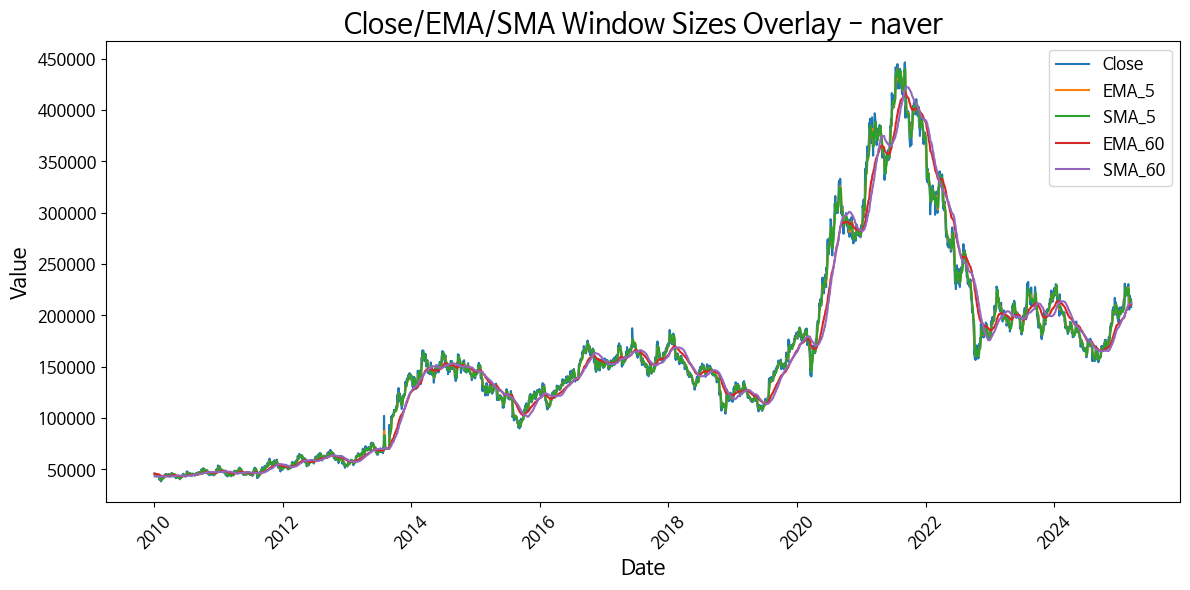

In [53]:
import matplotlib.pyplot as plt

# 그릴 컬럼명을 리스트에 정의
col_list = ['Close','EMA_5', 'SMA_5', 'EMA_60','SMA_60']

# x축: 날짜 인덱스
x = df_naver_add.index

plt.figure(figsize=(12, 6))
for col in col_list:
    plt.plot(x, df_naver_add[col], label=col)

plt.title('Close/EMA/SMA Window Sizes Overlay - naver', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


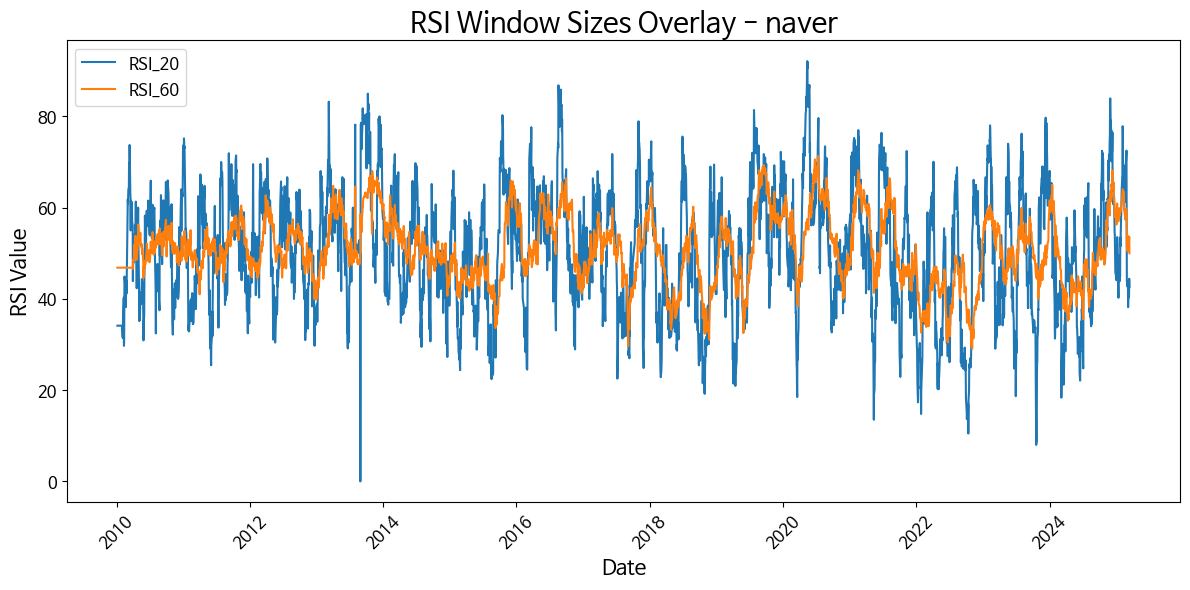

In [52]:
import matplotlib.pyplot as plt

# 그릴 컬럼명을 리스트에 정의
col_list = ['RSI_20', 'RSI_60']

# x축: 날짜 인덱스
x = df_naver_add.index

plt.figure(figsize=(12, 6))
for col in col_list:
    plt.plot(x, df_naver_add[col], label=col)

plt.title('RSI Window Sizes Overlay - naver', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('RSI Value', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
